## KTD

In [285]:
import numpy as np

class KalmanTD:
    """
    Extended Kalman Temporal Differences (KTD) implementation
    to support generalized value function approximation.
    """

    def __init__(self, num_features, tau, gamma, sigma_w, sigma_r, forward_model):
        """
        Initialize the KalmanTD instance.

        Parameters:
        - num_features: Number of features in the parameter vector theta.
        - tau: Process noise parameter (controls the covariance increase).
        - gamma: Discount factor.
        - sigma_w: Initial weight covariance scaling factor.
        - sigma_r: Standard deviation of the reward noise.
        - forward_model: A handle to the value function approximation model
          (non-linear with respect to theta).
        """
        self.num_features = num_features
        self.gamma = gamma
        self.sigma_r = sigma_r
        self.forward_model = forward_model  # Non-linear value function

        # Initialize weights mean (theta estimate) and covariance (Sigma)
        self.weights_mean = np.zeros((num_features, 1))  # Theta estimate
        self.weights_cov = (sigma_w ** 2) * np.identity(num_features)

        # Process noise covariance (Q = tau^2 * I)
        self.process_noise_cov = (tau ** 2) * np.identity(num_features)

    def predict(self):
        """
        Prediction step: Update the covariance with process noise.
        """
        self.weights_cov += self.process_noise_cov

    def update(self, actual_reward, state, next_state):
        """
        Perform the update step of the Extended Kalman Filter.

        Parameters:
        - actual_reward: Observed reward at time t.
        - state: Current state index.
        - next_state: Next state index.
        """
        # Current estimate of theta
        theta = self.weights_mean

        # Compute value function and its derivative at current and next states
        V_s = self.forward_model(theta.item())[state]
        V_s_prime = self.forward_model(theta.item())[next_state]

        # Compute the Jacobians (derivatives) at states s and s'
        grad_V_s = self.compute_jacobian(theta.item(), state)
        grad_V_s_prime = self.compute_jacobian(theta.item(), next_state)

        # Compute the observation model h_t and its Jacobian H_t
        h_t = -V_s + self.gamma * V_s_prime
        H_t = -grad_V_s + self.gamma * grad_V_s_prime  # (num_features x 1)

        # Innovation (prediction error)
        delta = actual_reward - h_t.item()

        # Kalman gain computation
        temp = self.weights_cov @ H_t
        denom = (H_t.T @ temp).item() + (self.sigma_r ** 2)
        kalman_gain = temp / denom  # (num_features x 1)

        # Update weights mean and covariance
        self.weights_mean += kalman_gain * delta
        self.weights_cov -= kalman_gain @ H_t.T @ self.weights_cov

    def compute_jacobian(self, theta, state):
        """
        Compute the derivative of the value function with respect to theta at a given state.

        Parameters:
        - theta: Current parameter value (scalar).
        - state: State index.

        Returns:
        - Jacobian vector (num_features x 1).
        """
        # Numerical approximation of the derivative
        epsilon = 1e-5
        V_plus = self.forward_model(theta + epsilon)
        V_minus = self.forward_model(theta - epsilon)
        derivative = (V_plus[state] - V_minus[state]) / (2 * epsilon)
        return np.array([[derivative.item()]])  # Ensure it's a column vector

    @staticmethod
    def default_kalman_td(num_features, forward_model):
        """
        Create a KalmanTD instance with default parameters.

        Parameters:
        - num_features: Number of features.
        - forward_model: Value function approximation model.

        Returns:
        - Instance of KalmanTD with default settings.
        """
        return KalmanTD(
            num_features=num_features,
            tau=np.sqrt(1e-3),
            gamma=0.98,
            sigma_w=np.sqrt(10),
            sigma_r=np.sqrt(0.1 * 10),
            forward_model=forward_model
        )


## EKI-KTD

In [294]:
from numpy.linalg import svd, solve
import scipy.linalg

def forward_model(H_matrix):
    """
    Creates a forward model function using the matrix H.
    
    Parameters:
    - H_matrix: A numpy array representing the observation matrix.
    
    Returns:
    - A function that takes the parameter ensemble (xi_ensemble) and returns the simulated observations.
    """
    def model(xi_ensemble):
        return H_matrix @ xi_ensemble.T
    
    return model

def enkf_step(xi_train_ensemble, H_func, y, sig_Q, sig_R, is_perturbing_y, using_SVD,iid_perturbating_y=False ):
    """
    Performs a single iteration step of the Ensemble Kalman Filter, with optional SVD optimization.

    Parameters:
    - xi_train_ensemble: Current ensemble of parameters
    - H_func: Function handle for the observation operator
    - y: Observation data
    - sig_Q: Standard deviation of process noise
    - sig_R: Standard deviation of observation noise
    - is_perturbing_y: Boolean flag indicating if observation noise should be added
    - using_SVD: Boolean flag indicating if SVD should be used for optimization

    Returns:
    - xi_train_ensemble: Updated ensemble of parameters after one iteration
    - xi_sample_mean: Mean of the ensemble
    """
    n_en, n_xi = xi_train_ensemble.shape

    # Prediction Step: Adding noise to the ensemble
    noise = np.random.normal(0, sig_Q, (n_en, n_xi))
    xi_train_ensemble += noise

    # Update the sample mean and covariance
    xi_sample_mean = np.mean(xi_train_ensemble, axis=0)
    xi_vec = xi_train_ensemble - xi_sample_mean

    # Simulate the observation using the observation function
    y_sim = H_func(xi_train_ensemble)
    y_sample_mean = np.mean(y_sim, axis=0)
    y_vec = y_sim - y_sample_mean

    if is_perturbing_y:
        if iid_perturbating_y:
            y_obs = y + np.random.normal(0, sig_R, y_sim.shape).T
        else:
            y_obs = y + np.random.normal(0, sig_R, y.shape)
    else:
        y_obs = y

    
    if using_SVD:
        # Compute the covariance matrix Y_p_t and use SVD for optimization
        obs_noise_cov_inv = (1/sig_R)**2 * np.eye(y.shape[0])
        Z_p_t = xi_vec / np.sqrt(n_en - 1)
        Y_p_t = y_vec / np.sqrt(n_en - 1)

        X = Y_p_t @ obs_noise_cov_inv @ Y_p_t.T
        U, S, Vt = svd(X)
        
        P = U 
        Γ = S # Γ is a vector

        tmp = np.dot(Y_p_t, obs_noise_cov_inv @ (y_obs - y_sim.T))
        tmp = np.dot(P.T, tmp)

        tmp *= (1 / (Γ + 1))[:, np.newaxis]
            
        tmp = np.dot(P, tmp)
        update = np.dot(Z_p_t.T, tmp)
    else:
        # Standard Kalman update without SVD
        Cov_yy = np.dot(y_vec.T, y_vec) / (n_en - 1)
        Cov_xiy =  np.dot(xi_vec.T, y_vec) / (n_en - 1)
        S = Cov_yy + sig_R**2 * np.eye(y.shape[0])
        temp = np.linalg.solve(S, y_obs - y_sim.T)
        update = Cov_xiy @ temp
    xi_train_ensemble += 1.01 * update.T
    xi_sample_mean = np.mean(xi_train_ensemble, axis=0)

    return xi_train_ensemble, xi_sample_mean

## Nonlinear approximation of function: Tsitsiklis Chain

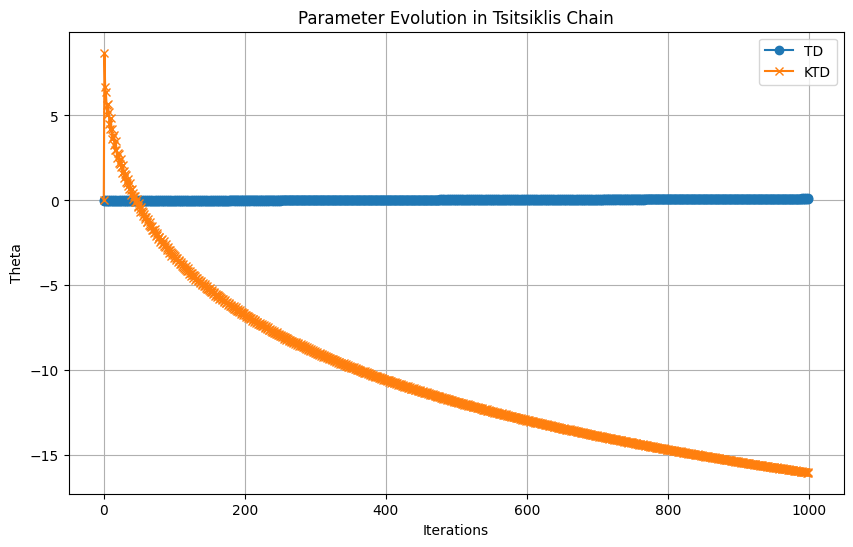

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
# from kalman_td import KalmanTD

# Define parameters for the Tsitsiklis Chain
epsilon = 0.15  # Small constant
gamma = 0.98    # Discount factor

# Initial value function vector V0
V0 = np.array([[10], [-7], [-3]])

# Transition matrix M
M = np.array([
    [1, 0.5, 1.5],
    [1.5, 1, 0.5],
    [0.5, 1.5, 1]
])

I = np.eye(3)  # Identity matrix

# Non-linear value function approximation model
def nonlinear_forward_model(theta):
    """
    Non-linear value function approximation model based on the Tsitsiklis Chain.

    V_hat(theta) = expm((M + epsilon * I) * theta) @ V0

    Parameters:
    - theta: Parameter value (scalar).

    Returns:
    - V_hat: Estimated value function vector.
    """
    return expm((M + epsilon * I) * theta) @ V0

# TD update function
def td_update(theta, alpha, V_hat, state, next_state, gamma):
    """
    Perform TD update for a single transition.

    Parameters:
    - theta: Current parameter value (scalar).
    - alpha: Learning rate.
    - V_hat: Current value function vector at theta.
    - state: Current state index.
    - next_state: Next state index.
    - gamma: Discount factor.

    Returns:
    - Updated theta value.
    """
    td_error = -V_hat[state] + gamma * V_hat[next_state]
    delta = td_error.item()  # Convert to scalar
    theta_new = theta + alpha * delta
    return theta_new

# Simulation parameters
num_iterations = 1000
alpha = 2e-3  # Learning rate for TD

# Initialize TD and KTD parameters
theta_td = 0.0  # Initial theta for TD
theta_td_list = [theta_td]

# Initialize KTD
ktd = KalmanTD.default_kalman_td(num_features=1, forward_model=nonlinear_forward_model)
theta_ktd_list = [ktd.weights_mean[0, 0]]

# State transitions in the Tsitsiklis Chain
transitions = [(0, 1), (1, 2), (2, 0)]

# Run the simulation
for i in range(num_iterations):
    for state, next_state in transitions:
        # TD Update
        V_hat_td = nonlinear_forward_model(theta_td)
        theta_td = td_update(theta_td, alpha, V_hat_td, state, next_state, gamma)
        theta_td_list.append(theta_td)

        # KTD Update 
        actual_reward = 0.0  # Tsitsiklis chain rewards are zero
        ktd.predict()
        ktd.update(actual_reward, state, next_state)
        theta_ktd_list.append(ktd.weights_mean[0, 0])

# Adjust the length of lists for plotting
theta_td_list = theta_td_list[:num_iterations]
theta_ktd_list = theta_ktd_list[:num_iterations]

# Plot the parameter trajectories
plt.figure(figsize=(10, 6))
plt.plot(theta_td_list, label="TD", marker='o')
plt.plot(theta_ktd_list, label="KTD", marker='x')
plt.title("Parameter Evolution in Tsitsiklis Chain")
plt.xlabel("Iterations")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)
plt.show()


## Nonstationary Chain: Boyan Chain

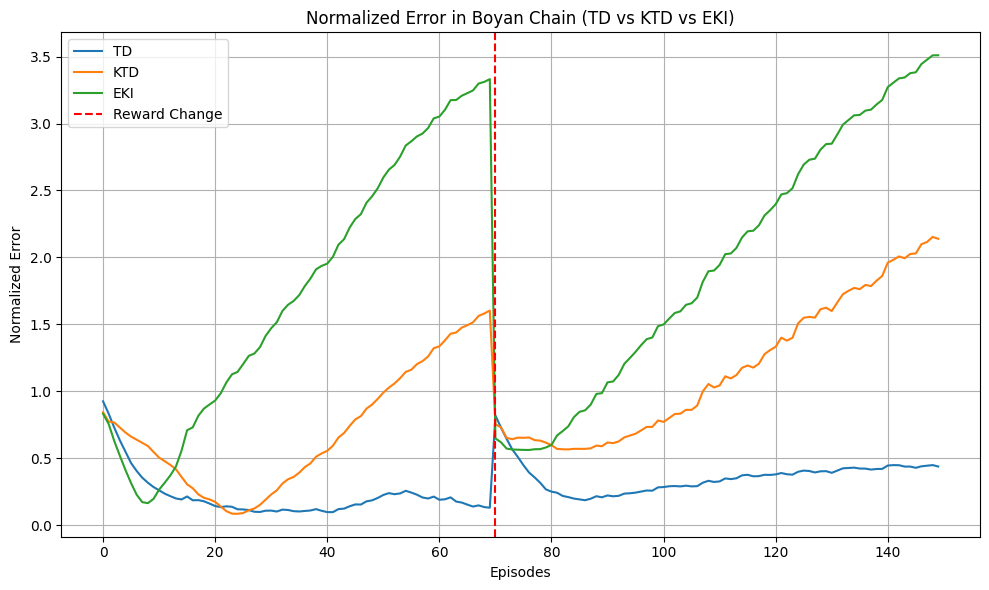

Final Parameters:
TD Theta: [-287.45989126 -218.17471703 -153.38548198  -78.2307333 ]
KTD Theta: [-422.24740754 -424.23634918 -427.18441644 -431.60088947]
EKI Theta: [-643.94198361 -639.64505649 -636.5385255  -633.21214348]
Optimal Theta: [-240. -160.  -80.    0.]


In [327]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, solve

# Boyan Chain Environment Setup
num_states = 13  # s0, s1, ..., s12
terminal_state = 0

base_reward_s1 = -2
base_reward_others = -3
reward_scale_change_episode = 70

def get_reward(state, episode_count):
    scale = 1.0 if episode_count < reward_scale_change_episode else 10.0
    if state == 1:
        return base_reward_s1 * scale
    elif state >= 2:
        return base_reward_others * scale
    else:
        return 0.0  # s0为终止状态，无奖励

def transition(state):
    if state == 0:
        return [(0, 1.0)]
    elif state == 1:
        return [(0, 1.0)]
    else:
        return [(state-1, 0.5), (state-2, 0.5)]

anchors = [0,4,8,12]
anchor_features = {
    0: np.array([0,0,0,1]),
    4: np.array([0,0,1,0]),
    8: np.array([0,1,0,0]),
    12:np.array([1,0,0,0])
}

def get_phi(s):
    if s in anchor_features:
        return anchor_features[s].copy()
    for i in range(len(anchors)-1):
        if anchors[i] < s < anchors[i+1]:
            s_left = anchors[i]
            s_right = anchors[i+1]
            phi_left = anchor_features[s_left]
            phi_right = anchor_features[s_right]
            ratio = (s - s_left) / (s_right - s_left)
            return (1-ratio)*phi_left + ratio*phi_right
    return np.zeros(4)

num_features = 4

theta_star_1 = np.array([-24,-16,-8,0], dtype=float)
theta_star_2 = 10.0 * theta_star_1

def get_optimal_theta(episode_count):
    if episode_count < reward_scale_change_episode:
        return theta_star_1
    else:
        return theta_star_2

def normalized_error(theta, theta_star):
    return np.linalg.norm(theta - theta_star) / np.linalg.norm(theta_star)

def value_function(theta, s):
    phi = get_phi(s)
    return phi @ theta

# TD update
def td_update(theta, alpha, s, s_next, r, gamma):
    v_s = value_function(theta, s)
    v_s_next = value_function(theta, s_next)
    delta = r + gamma * v_s_next - v_s
    return theta + alpha * delta * get_phi(s)


# KTD Implementation
class KTD:
    def __init__(self, num_features, gamma, sigma2=1e-2, eta=1e-3):
        self.num_features = num_features
        self.gamma = gamma
        self.theta_mean = np.zeros(num_features)
        self.P = np.eye(num_features)
        self.sigma2 = sigma2
        self.eta = eta
    
    def predict(self):
        self.P += self.eta * self.P

    def update(self, s, s_next, r):
        # h_theta = V(s) - gamma*V(s')
        v_s = value_function(self.theta_mean, s)
        v_s_next = value_function(self.theta_mean, s_next)
        h_theta = v_s - self.gamma * v_s_next
        delta = r - h_theta
        H = get_phi(s) - self.gamma * get_phi(s_next)  
        H = H.reshape(-1, 1)
        
        PH = self.P @ H
        S = H.T @ PH + self.sigma2
        K = PH / S
        self.theta_mean += (K.flatten() * delta)
        # infaltion of P to be stable
        inflation_factor = 0.999  
        self.P = (self.P - (K @ H.T) * S) * inflation_factor
        # self.P -= (K @ H.T) * S


# EKI Related functions

def forward_model_dynamic(s_snext_list, gamma):

    def model(xi_ensemble):
        n_en = xi_ensemble.shape[0]
        M = len(s_snext_list)
        pred = np.zeros((M, n_en))
        for i, (ss, ssn) in enumerate(s_snext_list):
            for j in range(n_en):
                theta_j = xi_ensemble[j,:]
                # g(theta) = V(s) - gamma V(s')
                g = value_function(theta_j, ss) - gamma * value_function(theta_j, ssn)
                pred[i,j] = g
        return pred.T  
    
    return model


# Testing
num_episodes = 150
alpha = 0.3
gamma = 0.99

# initializing TD and KTD
theta_td = np.zeros(num_features)
theta_ktd = KTD(num_features, gamma=gamma, sigma2=1e-2, eta=1e-3)

td_errors = []
ktd_errors = []

# EKI parameters
n_en = 300
sig_Q = 0.00000
sig_R = 0.015
is_perturbing_y = True
using_SVD = False
M = 10  # update EKI every M steps

m_0 = np.zeros(num_features)
P = 0.2**2 * np.eye(num_features)
xi_train_ensemble = m_0 + np.random.multivariate_normal(np.zeros(num_features), P, size=n_en)
eki_errors = []

for ep in range(num_episodes):
    s = 12
    theta_opt = get_optimal_theta(ep)
    # EKI data cache
    s_snext_list = []
    r_list = []

    while s != 0:
        transitions = transition(s)
        rand_val = np.random.rand()
        cum_prob = 0.0
        for s_next, p in transitions:
            cum_prob += p
            if rand_val <= cum_prob:
                break
        r = get_reward(s, ep)

        # TD
        theta_td = td_update(theta_td, alpha, s, s_next, r, gamma)

        # KTD
        theta_ktd.predict()
        theta_ktd.update(s, s_next, r)

        # EKI data cache
        s_snext_list.append((s, s_next))
        r_list.append(r)
        if len(r_list) == M:
            H_func = forward_model_dynamic(s_snext_list, gamma)
            y_obs = np.array(r_list).reshape(-1,1)
            xi_train_ensemble, xi_sample_mean = enkf_step(
                xi_train_ensemble, H_func, y_obs, sig_Q, sig_R, 
                is_perturbing_y, using_SVD
            )
            s_snext_list.clear()
            r_list.clear()

        s = s_next

    if len(r_list) > 0:
        H_func = forward_model_dynamic(s_snext_list, gamma)
        y_obs = np.array(r_list).reshape(-1,1)
        xi_train_ensemble, xi_sample_mean = enkf_step(
            xi_train_ensemble, H_func, y_obs, sig_Q, sig_R, 
            is_perturbing_y, using_SVD
        )

    # Error
    td_err = normalized_error(theta_td, theta_opt)
    ktd_err = normalized_error(theta_ktd.theta_mean, theta_opt)
    xi_sample_mean = np.mean(xi_train_ensemble, axis=0)
    eki_err = normalized_error(xi_sample_mean, theta_opt)

    td_errors.append(td_err)
    ktd_errors.append(ktd_err)
    eki_errors.append(eki_err)

# Plot
plt.figure(figsize=(10,6))
plt.plot(td_errors, label="TD")
plt.plot(ktd_errors, label="KTD")
plt.plot(eki_errors, label="EKI")
plt.axvline(x=reward_scale_change_episode, color='r', linestyle='--', label='Reward Change')
plt.title("Normalized Error in Boyan Chain (TD vs KTD vs EKI)")
plt.xlabel("Episodes")
plt.ylabel("Normalized Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Final Parameters:")
print("TD Theta:", theta_td)
print("KTD Theta:", theta_ktd.theta_mean)
print("EKI Theta:", xi_sample_mean)
print("Optimal Theta:", theta_opt)


### Averaging 10 trials

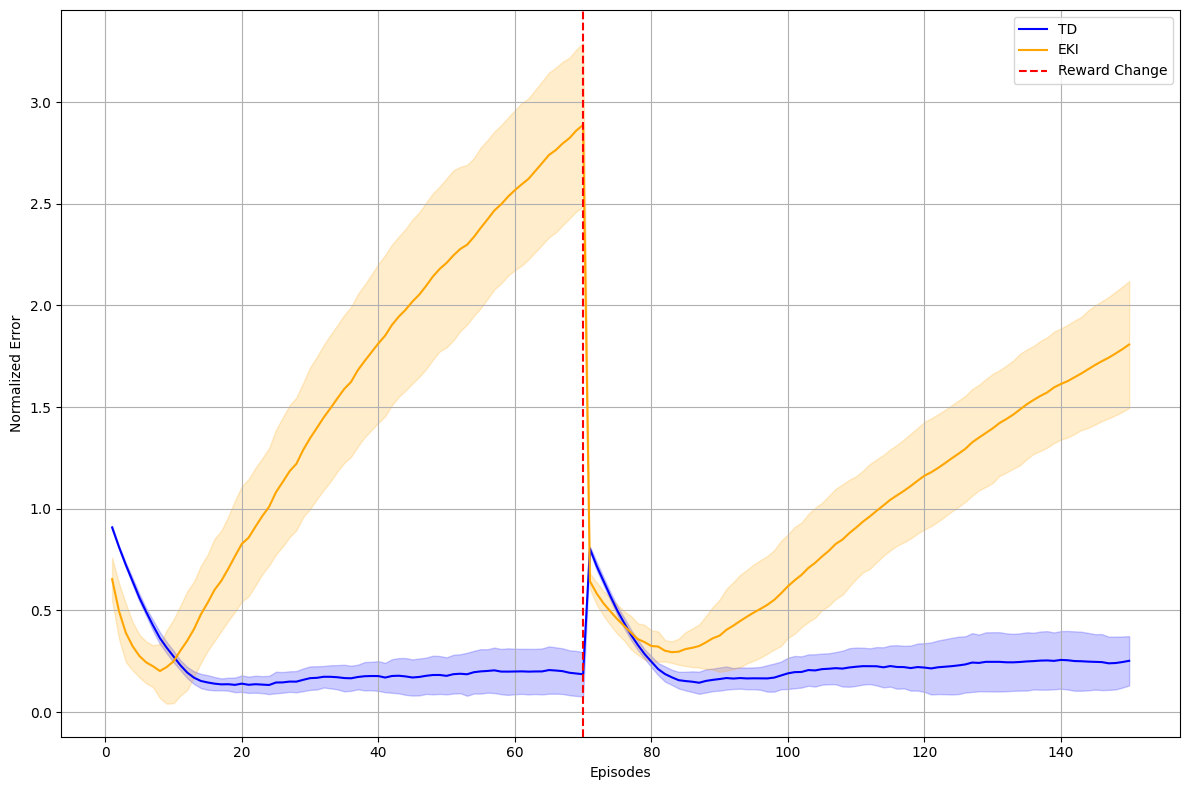

Episode: 150
TD Theta: [-261.11765344 -193.80640397 -111.09371056  -38.78894911]
KalmanTD Theta: [-2.41696568e+16 -3.29743704e+15 -6.87802517e+15 -1.20674698e+17]
EKI Theta: [-463.74634479 -402.00971109 -335.66406436 -272.31291221]
Optimal Theta: [-240. -160.  -80.    0.]


In [328]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, solve

# KalmanTD 
class KalmanTD:
    def __init__(self, num_features, tau, gamma, sigma_w, sigma_r, forward_model):
        self.num_features = num_features
        self.tau = tau
        self.gamma = gamma
        self.sigma_w = sigma_w
        self.sigma_r = sigma_r
        self.forward_model = forward_model
        self.weights_mean = np.zeros(num_features)
        self.weights_cov = np.eye(num_features) * 1.0

    def predict(self):
        # 状态预测（简单的模型）
        self.weights_mean = self.weights_mean  
        self.weights_cov += self.sigma_w**2 * np.eye(self.num_features)

    def update(self, r, s, s_next):
        phi = get_phi(s)
        phi_next = get_phi(s_next)
        target = r + self.gamma * (phi_next @ self.weights_mean)
        y = target - (phi @ self.weights_mean)
        S = phi @ self.weights_cov @ phi + self.sigma_r**2
        K = self.weights_cov @ phi / S
        self.weights_mean += K * y
        self.weights_cov = self.weights_cov - np.outer(K, phi) @ self.weights_cov


# Boyan Chain Environment Setup

num_states = 13
terminal_state = 0

base_reward_s1 = -2
base_reward_others = -3
reward_scale_change_episode = 70

def get_reward(state, episode_count):
    # return reward based on the s and episode_count
    scale = 1.0 if episode_count < reward_scale_change_episode else 10.0
    if state == 1:
        return base_reward_s1 * scale
    elif state >= 2:
        return base_reward_others * scale
    else:
        return 0.0  

def transition(state):
    if state == 0:
        return [(0, 1.0)]
    elif state == 1:
        return [(0, 1.0)]
    else:
        return [(state-1, 0.5), (state-2, 0.5)]

# Feature Representation
anchors = [0,4,8,12]
anchor_features = {
    0: np.array([0,0,0,1]),
    4: np.array([0,0,1,0]),
    8: np.array([0,1,0,0]),
    12:np.array([1,0,0,0])
}

def get_phi(s):
    if s in anchor_features:
        return anchor_features[s].copy()
    for i in range(len(anchors)-1):
        if anchors[i] < s < anchors[i+1]:
            s_left = anchors[i]
            s_right = anchors[i+1]
            phi_left = anchor_features[s_left]
            phi_right = anchor_features[s_right]
            ratio = (s - s_left) / (s_right - s_left)
            return (1-ratio)*phi_left + ratio*phi_right
    return np.zeros(4)

num_features = 4


# Optimal Parameters
theta_star_1 = np.array([-24,-16,-8,0], dtype=float)
theta_star_2 = 10.0 * theta_star_1

def get_optimal_theta(episode_count):
    if episode_count < reward_scale_change_episode:
        return theta_star_1
    else:
        return theta_star_2

def normalized_error(theta, theta_star):
    return np.linalg.norm(theta - theta_star) / np.linalg.norm(theta_star)

def value_function(theta, s):
    phi = get_phi(s)
    return phi @ theta

# TD Update
def td_update(theta, alpha, s, s_next, r, gamma):
    v_s = value_function(theta, s)
    v_s_next = value_function(theta, s_next)
    delta = r + gamma * v_s_next - v_s
    return theta + alpha * delta * get_phi(s)

# EKI Related Functions
def forward_model_dynamic(s_snext_list, gamma):
    """
    Create a forward_model function for EKI.
    """
    def model(xi_ensemble):
        n_en = xi_ensemble.shape[0]
        M = len(s_snext_list)
        pred = np.zeros((M, n_en))
        for i, (ss, ssn) in enumerate(s_snext_list):
            for j in range(n_en):
                theta_j = xi_ensemble[j,:]
                g = value_function(theta_j, ss) - gamma * value_function(theta_j, ssn)
                pred[i,j] = g
        return pred.T  # Returns shape (n_obs, n_en)
    return model


# Run Experiment (TD, KalmanTD, EKI)
def run_experiment():
    num_episodes = 150
    alpha = 0.3  # TD learning rate
    gamma = 0.99

    theta_td_init = np.zeros(num_features)
    
    kalman_td = KalmanTD(
        num_features=num_features,
        tau=np.sqrt(1e-3),
        gamma=gamma,
        sigma_w=np.sqrt(10),
        sigma_r=np.sqrt(0.1 * 10),
        forward_model=None  # 已在KalmanTD内部定义forward_model
    )

    # EKI paras
    n_en = 100  # ensemble size
    sig_Q = 1e-3 
    sig_R = 1e-2  
    is_perturbing_y = True
    using_SVD = False
    M = 1  

    # inialize EKI ensemble
    m_0 = np.zeros(num_features)
    P = 0.15**2 * np.eye(num_features)
    xi_train_ensemble_init = m_0 + np.random.multivariate_normal(np.zeros(num_features), P, size=n_en)
    
    td_errors_run = []
    ktd_errors_run = []
    eki_errors_run = []

    # KalmanTD initialization
    kalman_td_run = KalmanTD(
        num_features=num_features,
        tau=np.sqrt(1e-3),
        gamma=gamma,
        sigma_w=np.sqrt(10),
        sigma_r=np.sqrt(0.1 * 10),
        forward_model=None
    )
    theta_td = theta_td_init.copy()
    kalman_td_run.weights_mean = kalman_td.weights_mean.copy()
    kalman_td_run.weights_cov = kalman_td.weights_cov.copy()
    xi_train_ensemble = xi_train_ensemble_init.copy()
    
    for ep in range(num_episodes):
        s = 12
        theta_opt = get_optimal_theta(ep)
        s_snext_list = []
        r_list = []

        while s != 0:
            transitions_list = transition(s)
            rand_val = np.random.rand()
            cum_prob = 0.0
            for s_next, p in transitions_list:
                cum_prob += p
                if rand_val <= cum_prob:
                    break
            r = get_reward(s, ep)

            # TD Update
            theta_td = td_update(theta_td, alpha, s, s_next, r, gamma)

            # KalmanTD Update
            kalman_td_run.predict()
            kalman_td_run.update(r, s, s_next)

            # EKI data cashe
            s_snext_list.append((s, s_next))
            r_list.append(r)
            if len(r_list) == M:
                H_func = forward_model_dynamic(s_snext_list, gamma)
                y_obs = np.array(r_list).reshape(-1,1)
                xi_train_ensemble, xi_sample_mean = enkf_step(
                    xi_train_ensemble, H_func, y_obs, sig_Q, sig_R, 
                    is_perturbing_y, using_SVD
                )
                s_snext_list.clear()
                r_list.clear()

            s = s_next

        if len(r_list) > 0:
            H_func = forward_model_dynamic(s_snext_list, gamma)
            y_obs = np.array(r_list).reshape(-1,1)
            xi_train_ensemble, xi_sample_mean = enkf_step(
                xi_train_ensemble, H_func, y_obs, sig_Q, sig_R*0.6^ep, 
                is_perturbing_y, using_SVD
            )

        # error
        td_err = normalized_error(theta_td, theta_opt)
        ktd_err = normalized_error(kalman_td_run.weights_mean.flatten(), theta_opt)
        eki_err = normalized_error(xi_sample_mean, theta_opt)

        td_errors_run.append(td_err)
        ktd_errors_run.append(ktd_err)
        eki_errors_run.append(eki_err)

    return td_errors_run, ktd_errors_run, eki_errors_run, theta_td, kalman_td_run.weights_mean, xi_sample_mean


# averaging over multiple trials
num_runs = 10
td_errors_all = []
ktd_errors_all = []
eki_errors_all = []
final_thetas_td = []
final_thetas_ktd = []
final_thetas_eki = []

for run in range(num_runs):
    td_errs, ktd_errs, eki_errs, theta_td_final, theta_ktd_final, theta_eki_final = run_experiment()
    td_errors_all.append(td_errs)
    ktd_errors_all.append(ktd_errs)
    eki_errors_all.append(eki_errs)
    final_thetas_td.append(theta_td_final)
    final_thetas_ktd.append(theta_ktd_final)
    final_thetas_eki.append(theta_eki_final)

td_errors_all = np.array(td_errors_all)  # 形状: (num_runs, num_episodes)
ktd_errors_all = np.array(ktd_errors_all)
eki_errors_all = np.array(eki_errors_all)

td_errors_mean = np.mean(td_errors_all, axis=0)
ktd_errors_mean = np.mean(ktd_errors_all, axis=0)
eki_errors_mean = np.mean(eki_errors_all, axis=0)

td_errors_std = np.std(td_errors_all, axis=0)
ktd_errors_std = np.std(ktd_errors_all, axis=0)
eki_errors_std = np.std(eki_errors_all, axis=0)


plt.figure(figsize=(12,8))
episodes = np.arange(1, 151)

plt.plot(episodes, td_errors_mean, label="TD", color='blue')
plt.fill_between(episodes, td_errors_mean - td_errors_std, td_errors_mean + td_errors_std, color='blue', alpha=0.2)

# plt.plot(episodes, ktd_errors_mean, label="KalmanTD (KTD)", color='green')
# plt.fill_between(episodes, ktd_errors_mean - ktd_errors_std, ktd_errors_mean + ktd_errors_std, color='green', alpha=0.2)

plt.plot(episodes, eki_errors_mean, label="EKI", color='orange')
plt.fill_between(episodes, eki_errors_mean - eki_errors_std, eki_errors_mean + eki_errors_std, color='orange', alpha=0.2)

plt.axvline(x=reward_scale_change_episode, color='red', linestyle='--', label='Reward Change')

# plt.title("Boyan Chain中的归一化误差 (TD vs KalmanTD vs EKI) - 10次运行的平均值")
plt.xlabel("Episodes")
plt.ylabel("Normalized Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Episode: {150}")
print(f"TD Theta: {final_thetas_td[-1]}")
print(f"KalmanTD Theta: {final_thetas_ktd[-1]}")
print(f"EKI Theta: {final_thetas_eki[-1]}")
print(f"Optimal Theta: {get_optimal_theta(150)}")
